In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from cv2 import aruco
from cv2 import VideoCapture
import json5


In [2]:
DATA_ROOT = "/mnt/e/Workspace/CathederTelesurgery/Data/Videos/2024-7-25"
CAMERA_EXTRINSIC_FILE = f"{DATA_ROOT}/cam3.json"

class CameraIntrinsics:
    def __init__(self, matrix, distorsion):
        self.matrix = matrix
        self.distorsion = distorsion
    @classmethod
    def from_file(clazz, matlab_calib_file):
        with open(matlab_calib_file, 'r') as f:
            intrinsics = json5.load(f)['Intrinsics']
            matrix = [[intrinsics['FocalLength'][0], intrinsics['Skew'], intrinsics['PrincipalPoint'][0]],[0, intrinsics['FocalLength'][1], intrinsics['PrincipalPoint'][1]],[0, 0, 1]]
            distorsion = [intrinsics['RadialDistortion'][0], intrinsics['RadialDistortion'][1], 0, intrinsics['TangentialDistortion'][0], intrinsics['TangentialDistortion'][1]]
            print(f"Camera intrinsics loaded from {matlab_calib_file} with matrix {matrix} and distorsion {distorsion}")
            return clazz(np.array(matrix), np.array(distorsion))

camera_intrinsics = CameraIntrinsics.from_file(CAMERA_EXTRINSIC_FILE)

Camera intrinsics loaded from /mnt/e/Workspace/CathederTelesurgery/Data/Videos/2024-7-25/cam3.json with matrix [[1432.3535332200738, 0, 960.2200313693709], [0, 1429.1723905623064, 559.2987936897417], [0, 0, 1]] and distorsion [0.05127226330669162, -0.11659145397355779, 0, 0, 0]


In [3]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

def plot_multiple_meshes_3d(surfaces):
    
    # Create the figure and 3D axes
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    for i, points in enumerate(surfaces):
        if points.shape != (4, 3):
            raise ValueError("Each surface must have a shape of (4, 3), representing four 3D points.")
        
        x = points[:, 0]
        y = points[:, 1]
        z = points[:, 2]

        ax.scatter(x, y, z, color='r')

        # set point labels
        for j, txt in enumerate(['0', '1', '2', '3']):
            ax.text(x[j], y[j], z[j], txt, size=20, zorder=1, color='k')

        # Close the polygon by connecting the last point back to the first
        ax.plot([points[0, 0], points[1, 0]], [points[0, 1], points[1, 1]], [points[0, 2], points[1, 2]], color='b')
        ax.plot([points[1, 0], points[2, 0]], [points[1, 1], points[2, 1]], [points[1, 2], points[2, 2]], color='b')
        ax.plot([points[2, 0], points[3, 0]], [points[2, 1], points[3, 1]], [points[2, 2], points[3, 2]], color='b')
        ax.plot([points[3, 0], points[0, 0]], [points[3, 1], points[0, 1]], [points[3, 2], points[0, 2]], color='b')

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    
    plt.show()

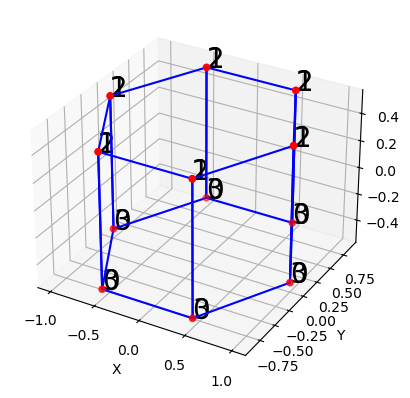

In [4]:
OBJ_SIZE = 12.7 / 1000 # in meters
TAG_SIZE = 9 / 1000 # in meters



def generate_tag_corners(center, tag_size, normal, rotation: int = 0):
    half_size = tag_size / 2

    corners_local = [
        [-half_size, half_size],   # Top-left
        [half_size, half_size],    # Top-right
        [half_size, -half_size],   # Bottom-right
        [-half_size, -half_size]   # Bottom-left
    ]

    # Rotate the corners
    coners_rotated = np.roll(corners_local, rotation, axis=0)
    
    corners_world = np.array([ np.cross([0, 0, 1], normal) * y + [0, 0, x] + center for [x, y] in coners_rotated], dtype=np.float32)
    return corners_world

def generate_hexagonal_cylinder_board(obj_size, tag_size, dict_name=cv2.aruco.DICT_APRILTAG_16h5, tag_rotations=[0 for i in range(6)], xy_offset = np.pi / 6):
    obj_points = []
    distance_origin = obj_size * np.cos(np.pi / 6)
    for i in range(6):
        normal_angle_w_x = 2 * np.pi / 6 * i + xy_offset
        center_x = distance_origin * np.cos(normal_angle_w_x)
        center_y = distance_origin * np.sin(normal_angle_w_x)
        # assign z = 0 in center:
        normal = np.array([np.cos(normal_angle_w_x), np.sin(normal_angle_w_x), 0])
        tag_center = np.array([center_x, center_y, 0])
        obj_points.append(generate_tag_corners(tag_center, tag_size, normal, tag_rotations[i]))
    # print(obj_points)
    return cv2.aruco.Board_create(obj_points, cv2.aruco.getPredefinedDictionary(dict_name), np.arange(len(obj_points)))

import matplotlib.pyplot as plt

surfaces = generate_hexagonal_cylinder_board(1, 1).objPoints
plot_multiple_meshes_3d(surfaces)

In [5]:
print(surfaces[0][0])
surfaces[1][3]

[ 0.5        0.8660254 -0.5      ]


array([ 0.5      ,  0.8660254, -0.5      ], dtype=float32)

In [6]:
def aruco_board_w_visualize(img, board, camera_intrinsics):
    result_img = img.copy()
    dictionary = board.dictionary
    params = aruco.DetectorParameters_create()
    corners, ids, rejectedImgPoints = aruco.detectMarkers(img, dictionary, parameters=params)
    if ids is not None:
        rvec = np.zeros(3)
        tvec = np.zeros(3)
        valid = aruco.estimatePoseBoard(corners, ids, board, camera_intrinsics.matrix, camera_intrinsics.distorsion, rvec, tvec)
        result_img = cv2.drawFrameAxes(result_img, camera_intrinsics.matrix, camera_intrinsics.distorsion, rvec, tvec, 30)
        return result_img, rvec, tvec, corners, ids
    else: return [None] * 5
    

In [7]:

def aruco_single(img, pattern=aruco.DICT_5X5_250, camera_intrinsics=CameraIntrinsics(None, None)):
    result_img = img.copy()
    pattern = aruco.getPredefinedDictionary(pattern)
    params = aruco.DetectorParameters_create()
    corners, ids, rejectedImgPoints = cv2.aruco.detectMarkers(img, pattern, parameters=params)
    if ids is not None:
        rvecs, tvecs, _ = aruco.estimatePoseSingleMarkers(corners, 0.05, camera_intrinsics.matrix, camera_intrinsics.distorsion)
        for i in range(len(ids)):
            result_img = aruco.drawDetectedMarkers(result_img, corners, ids)
            for i in range(len(ids)):
                result_img = cv2.drawFrameAxes(result_img, camera_intrinsics.matrix, camera_intrinsics.distorsion, rvecs[i,:,:], tvecs[i,:,:], 0.1)
        return result_img, corners, ids, rvecs, tvecs
    return [None]*5


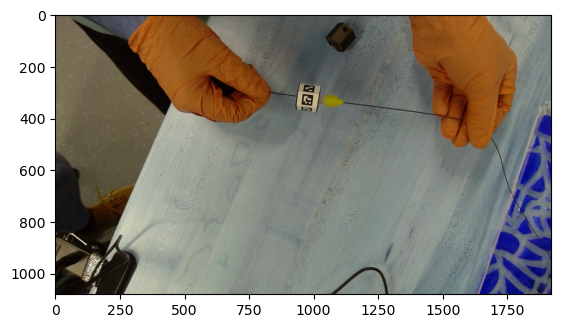

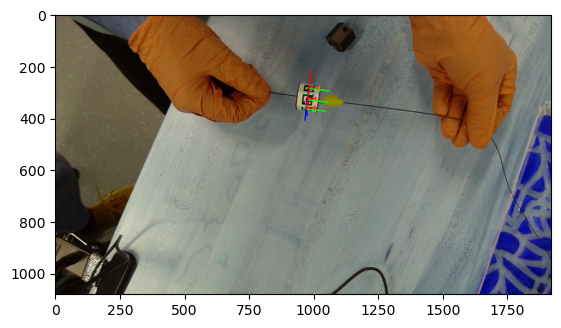

In [8]:
SESSION_ROOT = "/mnt/e/Workspace/CathederTelesurgery/Data/Datasets/ArucoVideo-7-25"
CUR_SESSION = "1-clip0"
test_img = cv2.imread(f"{SESSION_ROOT}/{CUR_SESSION}/frame0001.jpg")
test_result_img, *test_img_dets = aruco_single(test_img, pattern=cv2.aruco.DICT_4X4_1000, camera_intrinsics=camera_intrinsics)
# plt.subplot(1, 2, 1)
plt.imshow(test_img)
plt.show()       
# plt.subplot(1, 2, 2)
plt.imshow(test_result_img)
# test_img_dets

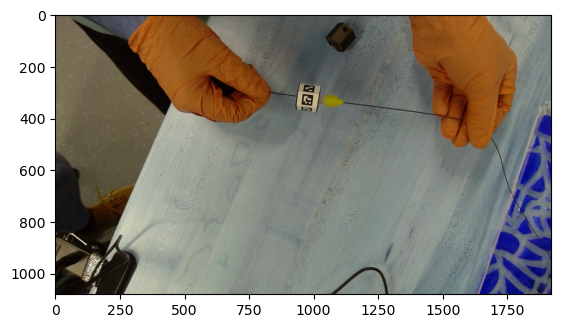

In [9]:
board = generate_hexagonal_cylinder_board(OBJ_SIZE, TAG_SIZE, cv2.aruco.DICT_4X4_1000, [0, 0, 0, 0, 0, 0], np.pi/6)
test_result_img_board, *test_img_dets_board = aruco_board_w_visualize(test_img, board, camera_intrinsics)
plt.imshow(test_result_img_board)

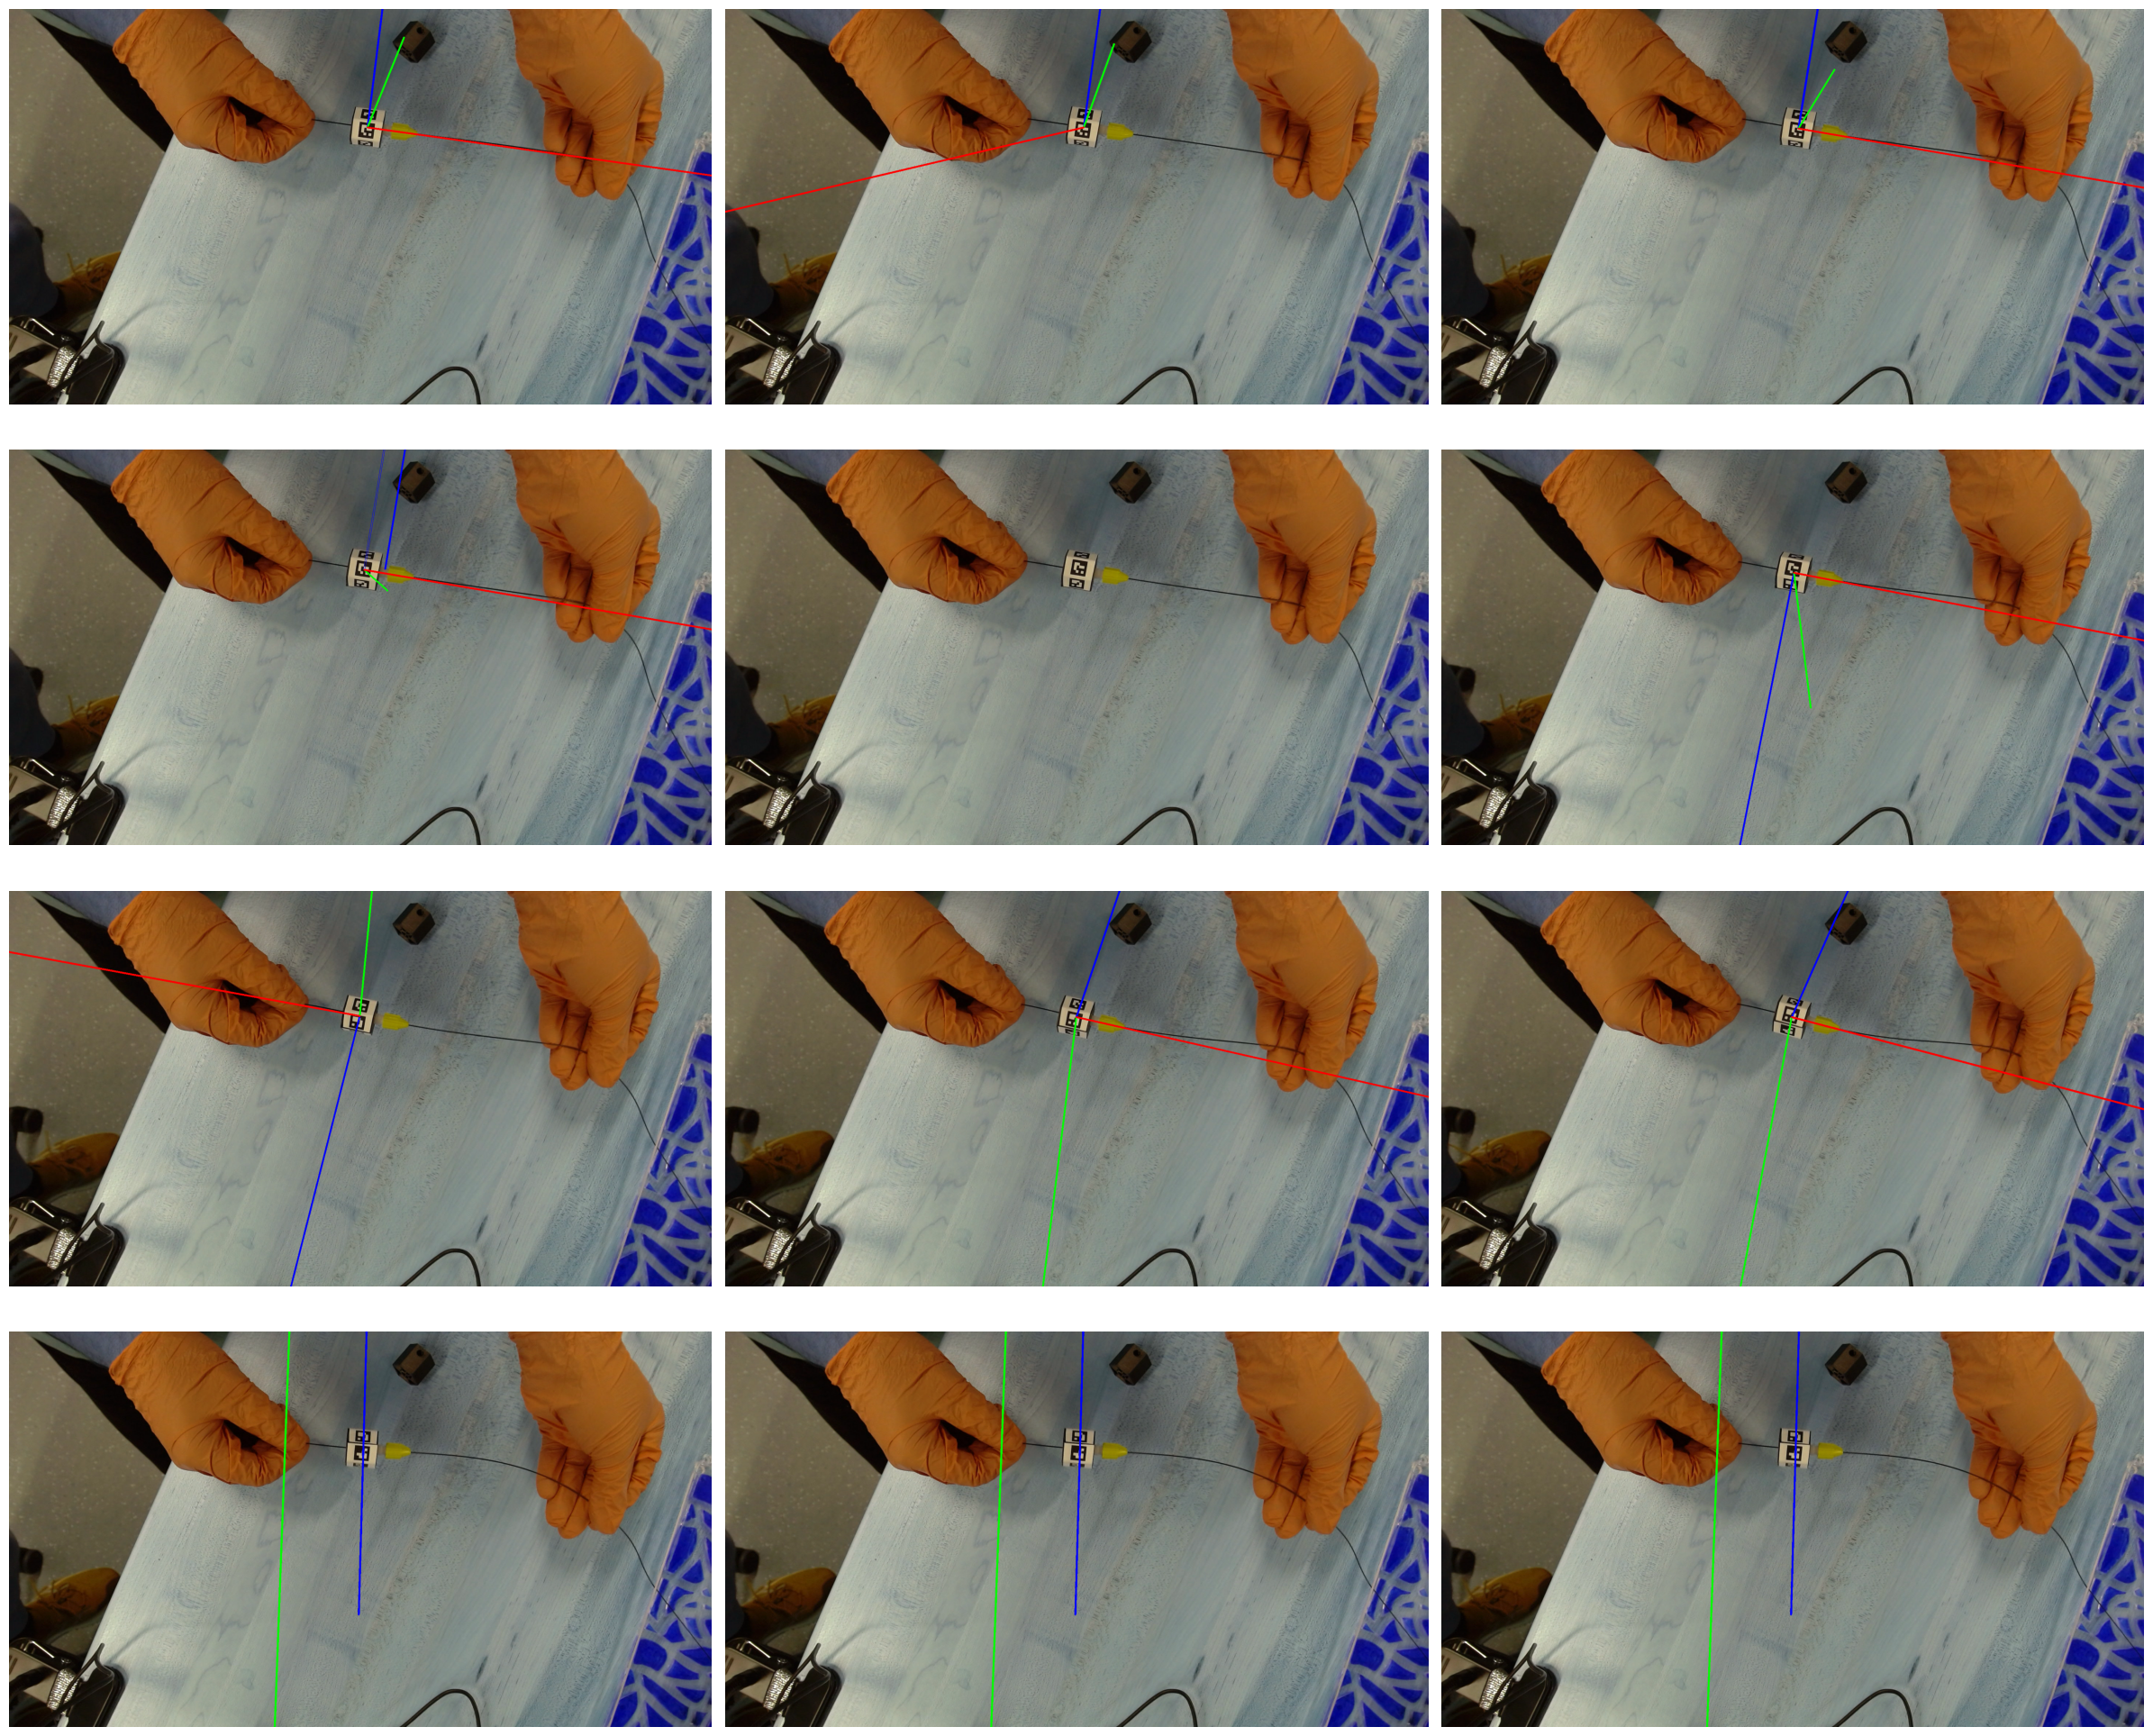

In [10]:
def test_multi_image(imgs, board, camera_intrinsics, shape=(4,3)):
    fig, axs = plt.subplots(shape[0], shape[1], figsize=(8*shape[1], 5*shape[0]))
    for i, img in enumerate(imgs):
        ax = axs[i // shape[1], i % shape[1]]
        result_img, *img_dets = aruco_board_w_visualize(img, board, camera_intrinsics)
        ax.imshow(result_img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()
board = generate_hexagonal_cylinder_board(OBJ_SIZE, TAG_SIZE, cv2.aruco.DICT_4X4_1000, [1 for _ in range(6)], np.pi/6)
test_multi_image([cv2.imread(f"{SESSION_ROOT}/{CUR_SESSION}/frame{i:04d}.jpg") for i in range(1, 13)], board, camera_intrinsics)

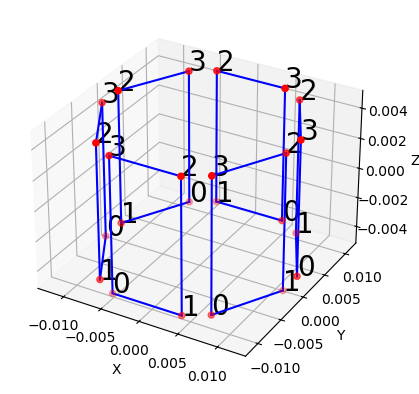

In [11]:
plot_multiple_meshes_3d(board.objPoints)

In [12]:
test_img_dets[3][1]

array([[ 0.02829439, -0.33865984,  1.78141917]])

In [13]:
test_img_dets_board[1]

array([ 0.00069046,  0.01529647, -0.02177806])

In [14]:
from tqdm import tqdm
import json
import numpyencoder

def track_through_frames_cylinder(image_list, result_dir, board, camera_intrinsics):
    if not os.path.exists(result_dir):
        os.makedirs(result_dir)
    rvecs = []
    tvecs = []
    for i, file in tqdm(enumerate(image_list)):
        detected = []
        result_img, rvec, tvec, corners, ids = aruco_board_w_visualize(cv2.imread(file), board, camera_intrinsics)
        if result_img is None:
            result_img = cv2.imread(file)
            result_img = cv2.putText(result_img, "No valid board pattern detected", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 255), 2)
            cv2.imwrite(f"{result_dir}/frame{i:04d}.jpg", result_img)
            with open(f"{result_dir}/frame{i:04d}.json", 'w') as f:
                json.dump([], f, cls=numpyencoder.NumpyEncoder)
            continue
        for j in range(len(ids)):
            detected.append({
                'id': ids[j][0],
                'corners': corners[j],
        })
        
        cv2.putText(result_img, f"Rotation vector: {rvec.tolist()}" , (10, 40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 255), 2)
        cv2.putText(result_img, f"Translation vector: {tvec.tolist()}" , (10, 100), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 255), 2)
        cv2.imwrite(f"{result_dir}/frame{i:04d}.jpg", result_img)

        with open(f"{result_dir}/frame{i:04d}.json", 'w') as f:
            json.dump({
                "detected": detected,
                "rvec": rvec.tolist(),
                "tvec": tvec.tolist()
            }, f, cls=numpyencoder.NumpyEncoder)
        rvecs.append(rvec)
        tvecs.append(tvec)
    os.system(f"ffmpeg -y -framerate 15 -i {result_dir}/frame%04d.jpg -r 15 -b:v 20M {result_dir}/composite.mp4")
    return rvecs, tvecs



In [15]:
# board = generate_hexagonal_cylinder_board(OBJ_SIZE, TAG_SIZE, cv2.aruco.DICT_4X4_50, [0, 0, 0, 0, 0, 0], np.pi/6)
rvecs, tvecs = track_through_frames_cylinder(
    image_list = [f"{SESSION_ROOT}/{CUR_SESSION}/{f}" for f in os.listdir(f"{SESSION_ROOT}/{CUR_SESSION}") if f.endswith('.jpg')], 
    result_dir = f"{SESSION_ROOT}/{CUR_SESSION}/aruco_board_rot_1_meter", 
    board=board,
    camera_intrinsics=camera_intrinsics
)

0it [00:00, ?it/s]

936it [01:55,  8.13it/s]
ffmpeg version 4.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.3.0 (crosstool-NG 1.23.0.449-a04d0)
  configuration: --prefix=/opt/conda/conda-bld/ffmpeg_1597178665428/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placeh --cc=/opt/conda/conda-bld/ffmpeg_1597178665428/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-pic --enable-pthreads --enable-shared --disable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 51.100 / 56. 51.100
  libavcodec     58. 91.100 / 58. 91.100
  libavformat    58. 45.100 / 58. 45.100
  libavdevice    58. 10.100 / 58. 10.100
  libavfilter     7. 85.100 /  7. 85.100
  libavresample   4.  0

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

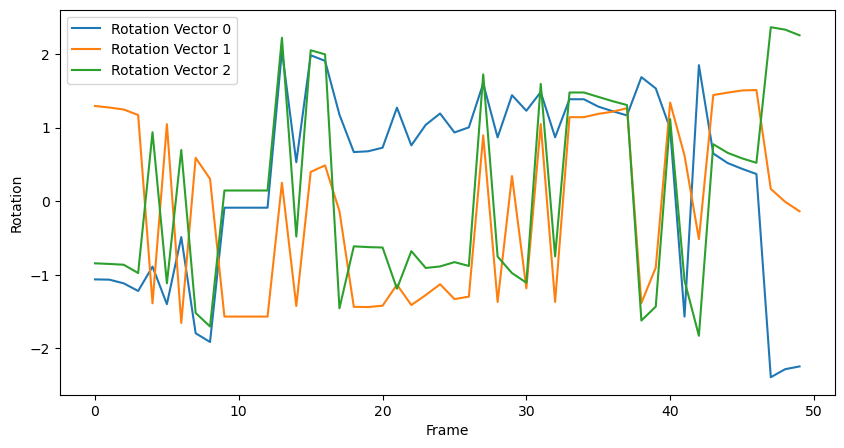

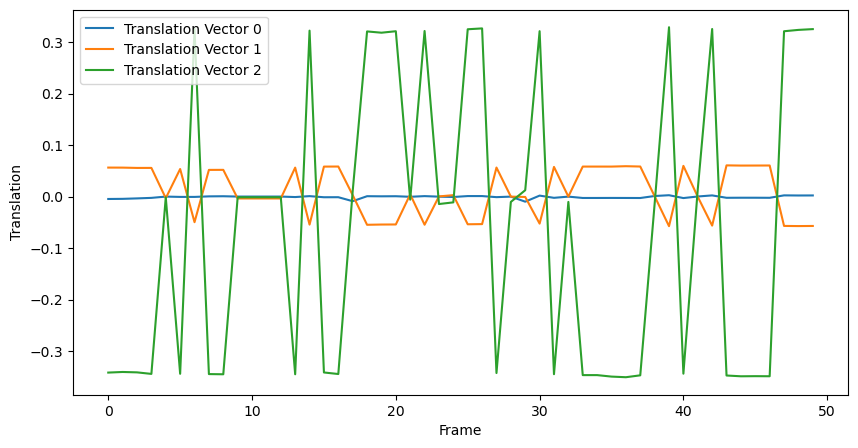

In [22]:
def plot_translations_3d(tvecs, fig=plt.figure()):
    tvecs = np.array(tvecs)
    ax = fig.add_subplot(111, projection='3d')
    
    # Unpacking tvecs into x, y, z coordinates
    x, y, z = tvecs[:, 0], tvecs[:, 1], tvecs[:, 2]
    
    # Plot the translations as a 3D line plot
    ax.plot(x, y, z, label='Translation Path', color='blue', alpha=0.6)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('3D Translation Path')
    
    plt.legend()
    plt.show()

def plot_rotations_3d(tvecs, rvecs, fig=plt.figure()):
    tvecs = np.array(tvecs)
    rvecs = np.array(rvecs)
    
    ax = fig.add_subplot(111, projection='3d')

    # Unpacking tvecs and rvecs into x, y, z and u, v, w components
    x, y, z = tvecs[:, 0], tvecs[:, 1], tvecs[:, 2]
    u, v, w = rvecs[:, 0], rvecs[:, 1], rvecs[:, 2]
    
    # Plot quivers (arrows) at each translation point representing rotation
    ax.quiver(x, y, z, u, v, w, length=0.05, normalize=True, label='Rotation Vectors')
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('3D Rotation Vectors')
    
    plt.legend()
    plt.show()

def plot_rotations_2d(rvecs):
    rvecs = np.array(rvecs)
    
    #plot in same figure overlayed
    plt.figure(figsize=(10, 5))
    plt.plot(rvecs[:, 0], label='Rotation Vector 0')
    plt.plot(rvecs[:, 1], label='Rotation Vector 1')
    plt.plot(rvecs[:, 2], label='Rotation Vector 2')
    plt.xlabel('Frame')
    plt.ylabel('Rotation')
    plt.legend()

    
    plt.show()

def plot_translations_2d(tvecs, absoluteValue=False):
    tvecs = np.array(tvecs)
    if absoluteValue:
        tvecs = np.abs(tvecs)

    #plot in same figure overlayed
    plt.figure(figsize=(10, 5))
    plt.plot(tvecs[:, 0], label='Translation Vector 0')
    plt.plot(tvecs[:, 1], label='Translation Vector 1')
    plt.plot(tvecs[:, 2], label='Translation Vector 2')
    plt.xlabel('Frame')
    plt.ylabel('Translation')
    plt.legend()


plot_rotations_2d(rvecs[0:50])
plot_translations_2d(tvecs[0:50], False)


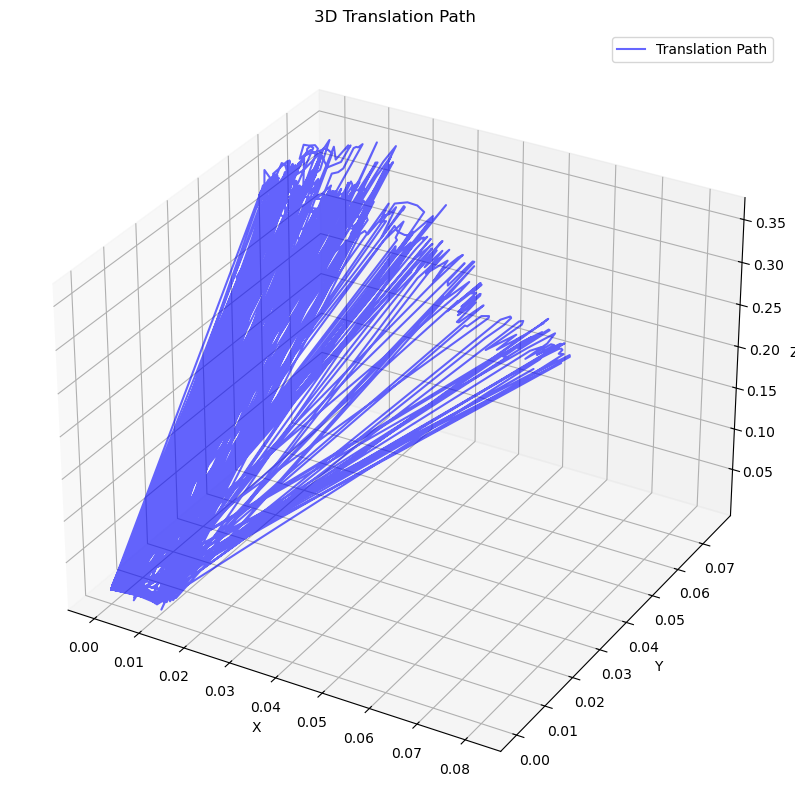

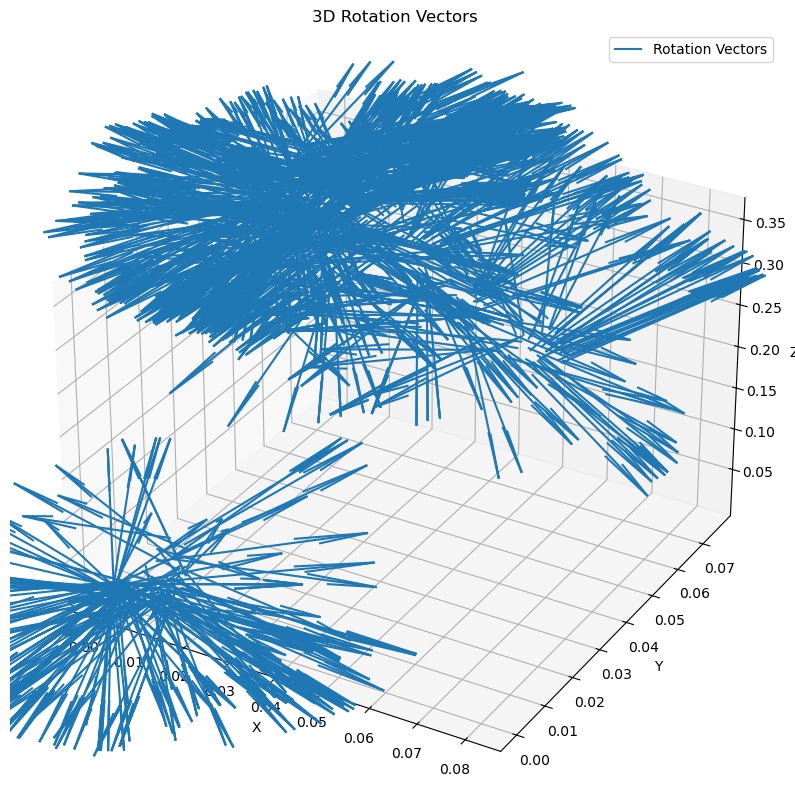

In [24]:
tvecs_A = np.abs(np.array(tvecs))
plot_translations_3d(tvecs_A, plt.figure(figsize=(30,10)))
plot_rotations_3d(tvecs_A, np.array(rvecs), plt.figure(figsize=(30,10)))

In [18]:
CUR_SESSION = "1-clip1"
track_through_frames(
    image_list = [f"{SESSION_ROOT}/{CUR_SESSION}/{f}" for f in os.listdir(f"{SESSION_ROOT}/{CUR_SESSION}") if f.endswith('.jpg')], 
    result_dir = f"{SESSION_ROOT}/{CUR_SESSION}/aruco", 
    pattern=cv2.aruco.DICT_4X4_50, 
    camera_intrinsics=camera_intrinsics
)

NameError: name 'track_through_frames' is not defined

In [ ]:
CUR_SESSION = "2-clip0"
track_through_frames(
    image_list = [f"{SESSION_ROOT}/{CUR_SESSION}/{f}" for f in os.listdir(f"{SESSION_ROOT}/{CUR_SESSION}") if f.endswith('.jpg')], 
    result_dir = f"{SESSION_ROOT}/{CUR_SESSION}/aruco", 
    pattern=cv2.aruco.DICT_APRILTAG_16h5, 
    camera_intrinsics=camera_intrinsics
)

312it [00:21, 14.24it/s]
ffmpeg version 4.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.3.0 (crosstool-NG 1.23.0.449-a04d0)
  configuration: --prefix=/opt/conda/conda-bld/ffmpeg_1597178665428/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placeh --cc=/opt/conda/conda-bld/ffmpeg_1597178665428/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-pic --enable-pthreads --enable-shared --disable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 51.100 / 56. 51.100
  libavcodec     58. 91.100 / 58. 91.100
  libavformat    58. 45.100 / 58. 45.100
  libavdevice    58. 10.100 / 58. 10.100
  libavfilter     7. 85.100 /  7. 85.100
  libavresample   4.  0

In [ ]:
CUR_SESSION = "2-clip1"
track_through_frames(
    image_list = [f"{SESSION_ROOT}/{CUR_SESSION}/{f}" for f in os.listdir(f"{SESSION_ROOT}/{CUR_SESSION}") if f.endswith('.jpg')], 
    result_dir = f"{SESSION_ROOT}/{CUR_SESSION}/aruco", 
    pattern=cv2.aruco.DICT_APRILTAG_16h5, 
    camera_intrinsics=camera_intrinsics
)

960it [01:03, 15.00it/s]
ffmpeg version 4.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.3.0 (crosstool-NG 1.23.0.449-a04d0)
  configuration: --prefix=/opt/conda/conda-bld/ffmpeg_1597178665428/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placeh --cc=/opt/conda/conda-bld/ffmpeg_1597178665428/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-pic --enable-pthreads --enable-shared --disable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 51.100 / 56. 51.100
  libavcodec     58. 91.100 / 58. 91.100
  libavformat    58. 45.100 / 58. 45.100
  libavdevice    58. 10.100 / 58. 10.100
  libavfilter     7. 85.100 /  7. 85.100
  libavresample   4.  0